### Identifying persons of interest in the Enron fraud case via machine learning.

The goal of this notebook is to build a supervised classifier identifying whether certain employees at Enron at the time of their fraud investigation are poi's, i.e., persons of interest to the investigation. The features in our dataset comprise of certain financial features such as salaries, bonuses, stock options, along with data regarding number of emails sent or received by the employees from known poi's. In another notebook, we conducted some exploratory analysis that highlighted the correlations of our features with being a poi and also looked at how many data points were missing for each feature. From this, we extracted certain features that we will use in our algorithm, namely: total_stock_value, total_payments, restricted_stock, exercised_stock_options, salary, expenses, other, from_poi_to_this_person, from_this_person_to_poi, shared_receipt_with_poi, bonus.

A comment on credit: this dataset was compiled as part of udacity's "Introduction to Machine Learning" course. This course provides lessons on how to use various modules in sklearn, and this poi identifier is the final project for the course. Their dataset also has text email data for 86 of the employees considered here, and more advanced features can be constructed from this data. However, for this particular analysis, we will ignore that data, and leave that as a project to be implemented in the future.

In [1]:
import sys
import pickle
import itertools
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
from sklearn.manifold import TSNE

Let's run our exploratory analysis notebook, primarily because we built some pandas dataframes in that notebook that should be useful.

['salary' 'to_messages' 'deferral_payments' 'total_payments'
 'loan_advances' 'bonus' 'email_address' 'restricted_stock_deferred'
 'deferred_income' 'total_stock_value' 'expenses'
 'from_poi_to_this_person' 'exercised_stock_options' 'from_messages'
 'other' 'from_this_person_to_poi' 'poi' 'long_term_incentive'
 'shared_receipt_with_poi' 'restricted_stock' 'director_fees']
18
salary                        51
to_messages                   60
deferral_payments            107
total_payments                21
loan_advances                142
bonus                         64
email_address                 35
restricted_stock_deferred    128
deferred_income               97
total_stock_value             20
expenses                      51
from_poi_to_this_person       60
exercised_stock_options       44
from_messages                 60
other                         53
from_this_person_to_poi       60
poi                            0
long_term_incentive           80
shared_receipt_with_poi     

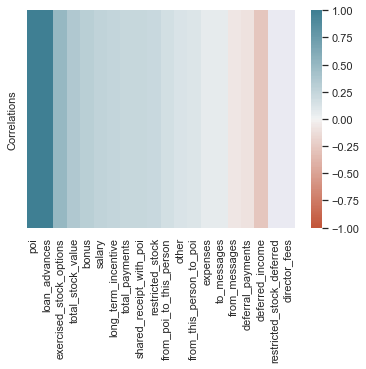

              poi  loan_advances  exercised_stock_options  total_stock_value  \
Correlations  1.0       0.999851                 0.503551           0.366462   

                 bonus    salary  long_term_incentive  total_payments  \
Correlations  0.302384  0.264976             0.254723        0.230692   

              shared_receipt_with_poi  restricted_stock  \
Correlations                 0.228313          0.224814   

              from_poi_to_this_person    other  from_this_person_to_poi  \
Correlations                 0.167722  0.12051                  0.11294   

              expenses  to_messages  from_messages  deferral_payments  \
Correlations  0.060292     0.058954      -0.074308          -0.098428   

              deferred_income  restricted_stock_deferred  director_fees  
Correlations        -0.265698                        NaN            NaN  
['LAY KENNETH L', 81525000.0]
['PICKERING MARK R', 400000.0]
['FREVERT MARK A', 2000000.0]


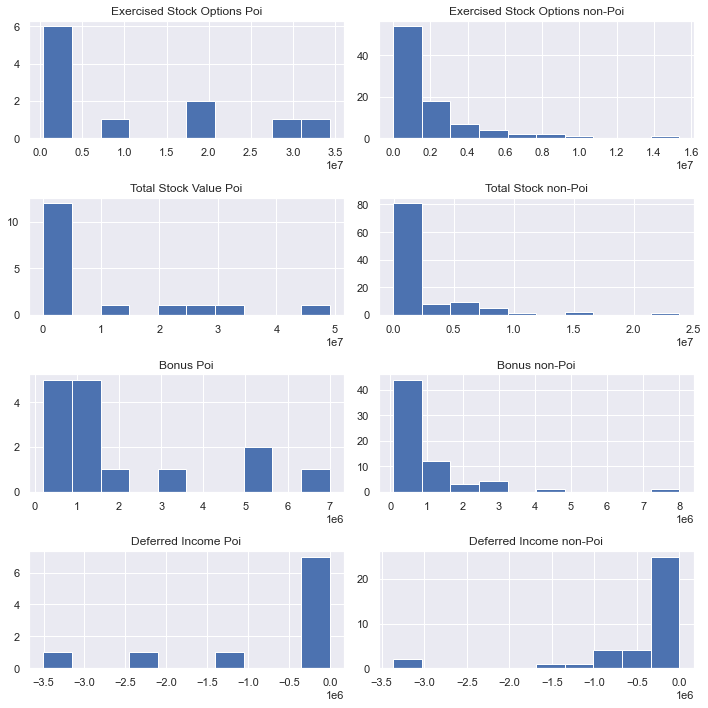

                      from_email_ratio  to_email_ratio
METTS MARK                    0.034483        0.047088
BAXTER JOHN C                      NaN             NaN
ELLIOTT STEVEN                     NaN             NaN
CORDES WILLIAM R              0.000000        0.013089
HANNON KEVIN P                0.656250        0.030622
...                                ...             ...
GRAMM WENDY L                      NaN             NaN
CAUSEY RICHARD A              0.244898        0.030655
TAYLOR MITCHELL S             0.000000        0.000000
DONAHUE JR JEFFREY M          0.500000        0.217341
GLISAN JR BEN F               0.375000        0.059565

[145 rows x 2 columns]
[0    0.339938
dtype: float64, 0    0.104406
dtype: float64]
                      total_stock_value  total_payments  restricted_stock  \
METTS MARK                     585062.0       1061827.0          585062.0   
BAXTER JOHN C                10623258.0       5634343.0         3942714.0   
ELLIOTT STEVEN          

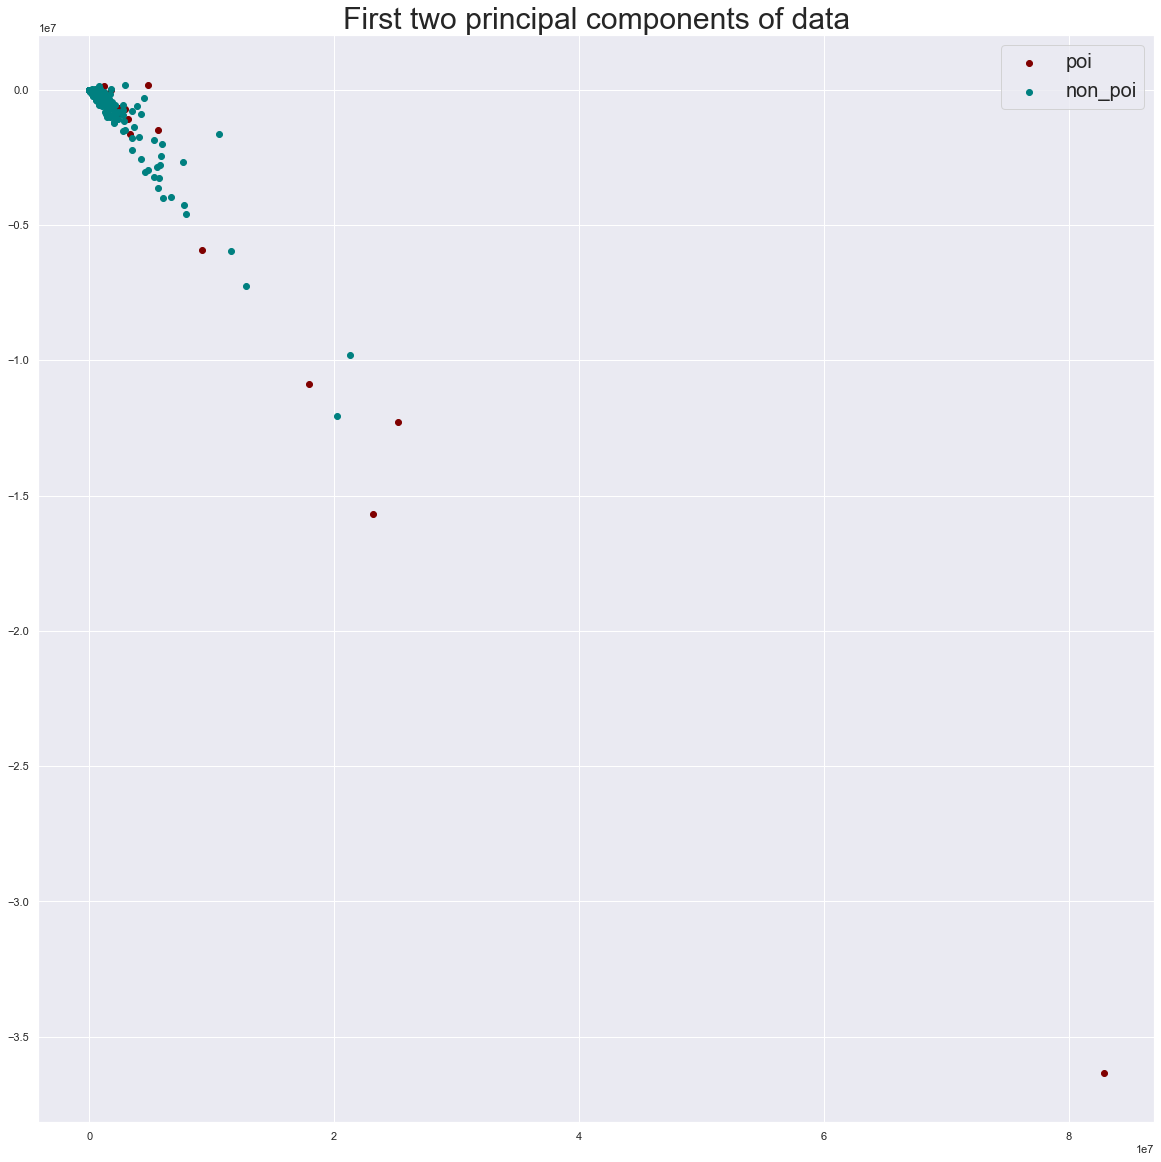

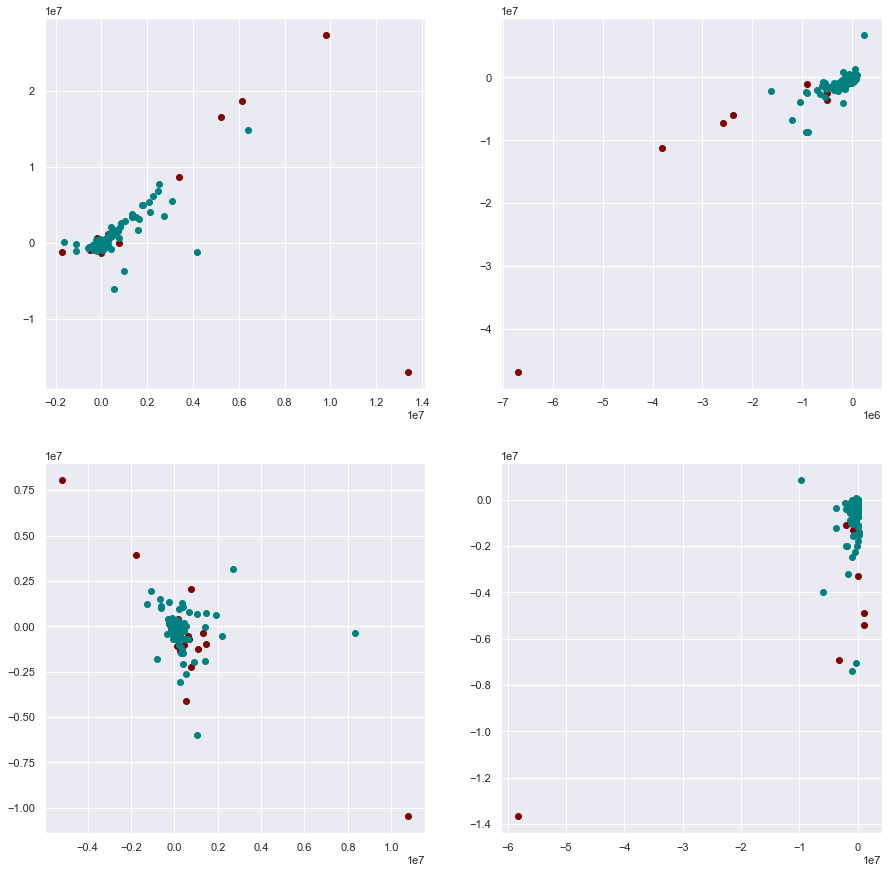

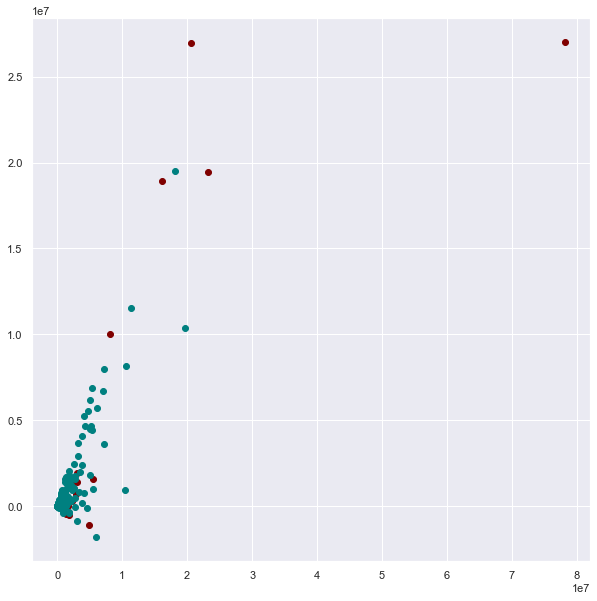

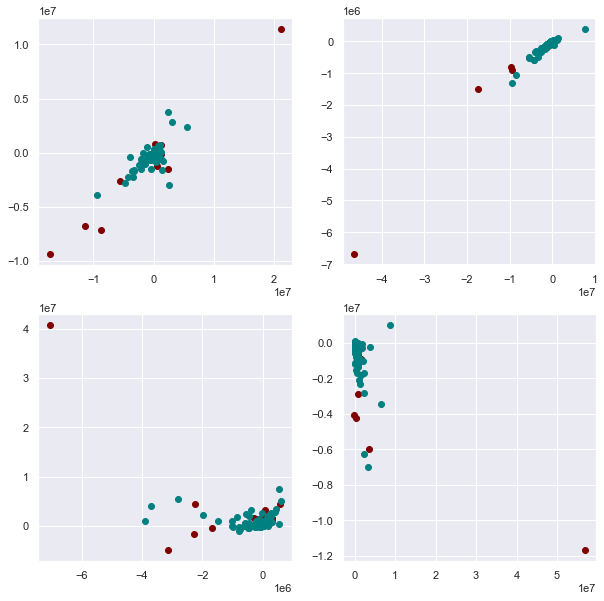

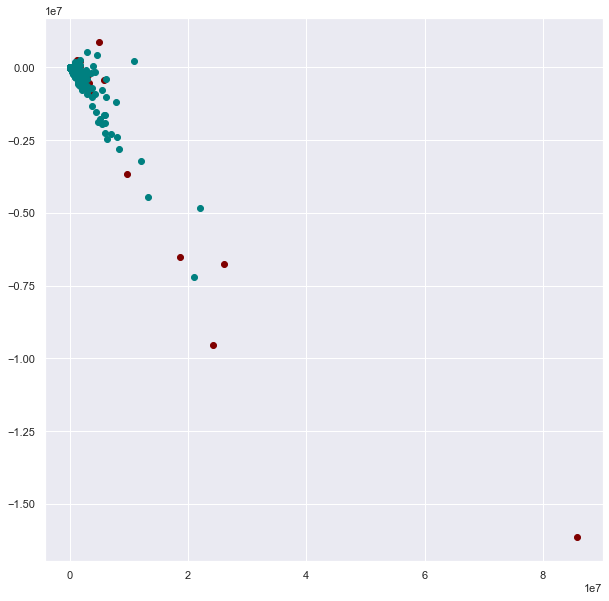

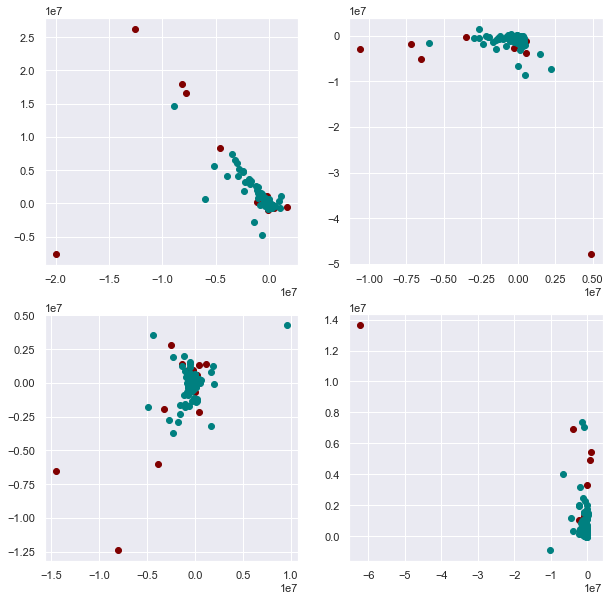

In [2]:
%run Poi_Exploratory_Analysis.ipynb 

Our primary dataset will be the dataframe we constructed without the "TOTAL" index and the "email_addresses" column. We will then shrink this dataset to only include the features we want.

In [3]:
print(df_no_total_no_address.columns.values)

['salary' 'to_messages' 'deferral_payments' 'total_payments'
 'loan_advances' 'bonus' 'restricted_stock_deferred' 'deferred_income'
 'total_stock_value' 'expenses' 'from_poi_to_this_person'
 'exercised_stock_options' 'from_messages' 'other'
 'from_this_person_to_poi' 'poi' 'long_term_incentive'
 'shared_receipt_with_poi' 'restricted_stock' 'director_fees'
 'from_email_ratio' 'to_email_ratio']


In [4]:
target = df_no_total_no_address.loc[:,"poi"]
target_array = target.to_numpy()

Rather than using our correlation coefficients to select features, let us initially start with all features. We will train a Decision Tree on these features and then use feature importance to identify the more relevant features and prune the less relevant ones out. 

In [5]:
feature_list = ['salary', 'restricted_stock', 'director_fees', 'deferral_payments', 'total_payments',
                 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income',
                 'total_stock_value', 'expenses', 'long_term_incentive', 'other', 'exercised_stock_options', 
                 'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 
                 'shared_receipt_with_poi', 'from_email_ratio', 'to_email_ratio']

financial_features = ['salary', 'restricted_stock', 'director_fees', 'deferral_payments', 'total_payments',
                       'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income',
                       'total_stock_value', 'expenses', 'long_term_incentive', 'other', 'exercised_stock_options']
full_email_features = ['to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 
                        'shared_receipt_with_poi']
normalized_email_ratios = ['from_email_ratio', 'to_email_ratio']


feature_dataframe = df_no_total_no_address.loc[:, feature_list]


One major issue that came up when we analyzed the data was the large number of missing values. We're going to deal with that here by imputing a value of zero for these NaN values. We've done this in our exploratory analysis notebook, but for readability of code, I will repeat it here. We'll also create poi and non_poi specific dataframes with NaN's replaced with zeros.

In [6]:
features_with_zeros = feature_dataframe.replace(to_replace=np.nan, value=0.)

sorted_df_with_ratios = df_no_total_no_address.sort_values(by="poi", ascending=False)
sorted_df_poi_with_ratios = sorted_df_with_ratios.iloc[:17]
sorted_df_non_poi_with_ratios = sorted_df_with_ratios.iloc[18:]

sorted_df_poi = sorted_df_poi_with_ratios.loc[:, feature_list]
sorted_df_non_poi = sorted_df_non_poi_with_ratios.loc[:, feature_list]

poi_with_zeros = sorted_df_poi.replace(to_replace=np.nan, value=0.)
non_poi_with_zeros = sorted_df_non_poi.replace(to_replace=np.nan, value=0.)
None

We are close to being able to train a classifier against the data but we first need to standardize the financial features and the email data that isn't normalized. 

In [7]:
scaler = MinMaxScaler()
def FinancialScaler(df, poi_df, non_poi_df):
    '''Given a dataframe with column indices subsets of feature_list above, and a seperation of the data frame into 
        poi and non_poi pieces, scale the columns aside from the normalized email ratios and return the scaled 
         dataframes. The dataframes should not have missing values.'''
    scaled_df, scaled_poi, scaled_non_poi = df.copy(), poi_df.copy(), non_poi_df.copy()
    finance_scale = scaler.fit(df.loc[:, financial_features])
    scaled_df[financial_features] = finance_scale.transform(df.loc[:, financial_features])
    scaled_poi[financial_features] = finance_scale.transform(poi_df.loc[:, financial_features])
    scaled_non_poi[financial_features] = finance_scale.transform(non_poi_df.loc[:, financial_features])
    
    email_scale = scaler.fit(df.loc[:, full_email_features])
    scaled_df[full_email_features] = email_scale.transform(df.loc[:, full_email_features])
    scaled_poi[full_email_features] = email_scale.transform(poi_df.loc[:, full_email_features])
    scaled_non_poi[full_email_features] = email_scale.transform(non_poi_df.loc[:, full_email_features])
    
    return scaled_df, scaled_poi, scaled_non_poi
            
scaled_features, scaled_poi, scaled_non_poi = FinancialScaler(features_with_zeros, poi_with_zeros, non_poi_with_zeros)
feature_array, poi_array, non_poi_array = scaled_features.to_numpy(), scaled_poi.to_numpy(), scaled_non_poi.to_numpy()

The next step we want to adopt is feature selection. We have not that much data points and a lot of different features for each data here. It will be useful to prune the less relevant features. To do so, we will train a decision tree classifier on the full data and print out the feature importances, and then remove features with 0 importance.

In [8]:
dtc_full = DecisionTreeClassifier()
clf = dtc_full.fit(feature_array, target_array)


feature_importances_list = clf.feature_importances_.tolist()
relevant_feature_index = [i for i in range(0, len(feature_importances_list)) if feature_importances_list[i]>0]

relevant_features_gini = [feature_list[i] for i in relevant_feature_index]
print(relevant_features_gini)

dtc2_full = DecisionTreeClassifier(criterion="entropy")
clf2 = dtc2_full.fit(feature_array, target_array)


feature_importances_list2 = clf2.feature_importances_.tolist()
relevant_feature_index2 = [i for i in range(0, len(feature_importances_list)) if feature_importances_list2[i]>0]

relevant_features_entropy = [feature_list[i] for i in relevant_feature_index2]
print(relevant_features_entropy)

['restricted_stock', 'total_payments', 'bonus', 'expenses', 'long_term_incentive', 'other', 'exercised_stock_options', 'shared_receipt_with_poi', 'from_email_ratio']
['salary', 'expenses', 'long_term_incentive', 'other', 'from_poi_to_this_person', 'shared_receipt_with_poi', 'from_email_ratio', 'to_email_ratio']


Let's create some new dataframes only recording these features.

In [9]:
relevant_features_df_gini = features_with_zeros.loc[:, relevant_features_gini]
relevant_features_df_entropy = features_with_zeros.loc[:, relevant_features_entropy]

relevant_gini_array = relevant_features_df_gini.to_numpy()
relevant_entropy_array = relevant_features_df_entropy.to_numpy()

We can now start training our model. To do so, let me explain the strategy we will use. We have a number of issues with our data. The first was the missing values, which we have dealt with, albeit in an unsatisfactory way. The second is the presence of a few major outliers in the financial data that are important poi. To deal with this, we will try to use algorithms that are robust to these type of outliers that are very far away from other points, such as Random Forests. Third, we have a major imbalanced class problem. As a first attempt to solve this, we will use stratified splits on our data. However, this is unlikely to be enough of a solution, so later, we will attempt to use some oversampling methods. Finally, we have a largely unresolvable issue that we just don't have much data and . To alleviate this, we will score our models using stratified shuffle splits. Multiple folds of this split method will act as resampling the data with replacement, and we will retrain our models on these splits and tally up the true positives, false negatives and false positives to compute the overall precision and accuracy over the splits. This scoring system will be used over different models, so we should write a function that does this for us.

In [10]:
def StratifiedScore(features, classifier, n_splits, test_size, random_state=None, targets = target_array):
    sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
    true_pos=0
    false_neg=0
    false_pos=0
    for train_ix, test_ix in sss.split(features, targets):
        features_train, targets_train = features[train_ix, :], targets[train_ix]
        features_test, targets_test = features[test_ix, :], targets[test_ix]
        classifier.fit(features_train, targets_train)
        predictions = classifier.predict(features_test)
        if predictions[i]==1 and targets_test[i]==1:
            true_pos+=1
        if predictions[i]==1 and targets_test[i]==0:
            false_pos+=1    
        if predictions[i]==0 and targets_test[i]==1:
            false_neg+=1
    precision = true_pos/(false_pos + true_pos)
    recall = true_pos/(false_neg + true_pos)
    
    return [precision, recall]
            
        

Let's see what the stratified score for our default decision tree classifier looks like. 

In [11]:
dtc = DecisionTreeClassifier()
print(StratifiedScore(features = relevant_gini_array, n_splits=1000, test_size=0.3, classifier=dtc, random_state=42))

NameError: name 'i' is not defined

This is already not the worst baseline. The udacity project guidelines have a baseline of 0.3 precision and recall so this is surpassing that. Our next goal is to improve the decision tree model by tuning the hyperparameters but we have to manage one big issue: we have so little data that overfitting is a major problem. Cross-validation can help fix this but we also need to use cross-validation to tune our hyperparameters. Using the same cross-validation sets to do both will lead to overfitting, as the hyperparameters will attune to the testing set. So, we will use nested cross-validation. We first create a parameter grid for our chosen classifier, which at this moment is a decision tree, to create a grid of classifiers. We will then use our scorer to score each classifier multiple times using smaller splits, and if the scores are relatively stable over the different splits, we can be reasonably confident hyperparameter tuning is not causing overfitting. If we are confident on this and find the tree to have good score, we can then simply tune our decision tree on the whole dataset using the stratified splits. We've already measured the performance of the tree using our nested splits, so we don't need to hold out a training set. For a decision tree, we will simply focus first on two hyperparameters: the criterion and the min_samples_split.

In [ ]:
def ParameterTuples(parameter_grid):
    '''Input must be a dictionary containing a grid of parameter values where each key is a parameter and 
        the value is a list of parameter values. Returns all possible combinations of parameters.'''
    list_of_parameters = []
    list_of_values = []
    for entry in parameter_grid.keys():
        list_of_parameters.append(entry)
        list_of_values.append(parameter_grid[entry])
        # Taking cartesian product
        list_of_parameter_tuples = []
        for i in itertools.product(*list_of_values):
            list_of_parameter_tuples.append(i)
                   
    return [list_of_parameters, list_of_parameter_tuples]

param_dtc = {'criterion': ['gini','entropy'], 'min_samples_split': [2, 10, 20]}
print("Example: ", ParameterTuples(param_dtc))

def ClassifierGrid(classifier, parameter_grid):
    '''Input is a dictionary of parameter values to try, returns a list of all clssifiers created by taking 
        parameter combinations.'''
    list_of_classifiers = []
    par, tup = ParameterTuples(parameter_grid)
    for i in range(len(tup)):
        params = {}
        for j in range(len(tup[i])):
            params[par[j]] = tup[i][j]
        clf = classifier(**params)
        list_of_classifiers.append(clf)
        
    return list_of_classifiers
dtc2 = DecisionTreeClassifier
print("Example: ", ClassifierGrid(dtc2, param_dtc))

classifier_grid_dtc = ClassifierGrid(dtc2, param_dtc)

We can now iterate through this list of classifiers and run our scorer and record the scores.

In [ ]:
def ScoreGrid(classifier_grid, features, test_size, n_splits, n_iter, targets=target_array):
    scores_per_classifier = []
    for entry in classifier_grid:
        score_list = [entry]
        for j in range(n_iter):
            score=StratifiedScore(classifier=entry, features=features, n_splits=n_splits, test_size=test_size, targets=targets)
            score_list.append(score)
        scores_per_classifier.append(score_list)
    return scores_per_classifier

print(ScoreGrid(classifier_grid=classifier_grid_dtc, features=relevant_gini_array, test_size=0.3, n_splits=1000,n_iter=10))

The results of these iterated score computations is interesting. First, it seems clear that entropy as criterion and min_samples_split give us the best scores, both in terms of best mean precision and recall and lowest variance. The scores are still not great, but given the quality of the data, it is reasonably promising. Moreover, the variance in scores is reasonable for any parameter values of the decision tree. One thing I want to emphasize is that this is not true nested cross-validation, and there is still some danger of overfitting. Ideally we would want to keep a holdout set to test that is not part of the cross-validation, but this is largely impossible to do here with only 145 data points on top of an imbalanced class issue making our metrics useless without the repeated sampling approach. Having determind that a decision tree is a suitable model, we now tune our hyperparameters using a single iteration of ScoreGrid on the whole data. 

In [ ]:
dtc3 = DecisionTreeClassifier
param_grid_dtc3 = {'criterion': ['gini','entropy'], 'min_samples_split': [2, 5, 10, 16, 20, 24, 50]}

print(ScoreGrid(classifier_grid=ClassifierGrid(dtc3, param_grid_dtc3), features=relevant_gini_array, test_size=0.3, n_splits=1000, n_iter=1))

From this, it is clear that our best model is a decision tree using entropy with min_samples_split=20. This gives us a precision of 0.34 and a recall of 0.49. We want to continue to improve this model. To this effect, we want to attack two isses. The first is the aforementioned issue of overfitting. A reasonable solution to this is to use an ensemble method, hence we will try to fit a Random Forest Classifier to the data and use the same method to tune hyperparameters. The second issue we want to tackle is the imbalanced class problem, which we will attempt to alleviate via oversampling. We will tackle these issues in order.